In [1]:
# 1.

import pandas as pd

df = pd.read_csv('Imdb.csv')

df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [2]:
# Check for missing values
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


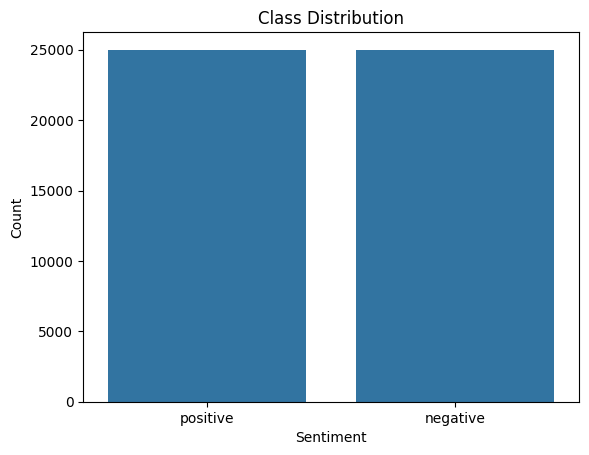

sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64


In [3]:
# Class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df)
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Value counts
print(df['sentiment'].value_counts(normalize=True))

count    50000.000000
mean       231.146580
std        171.349956
min          1.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


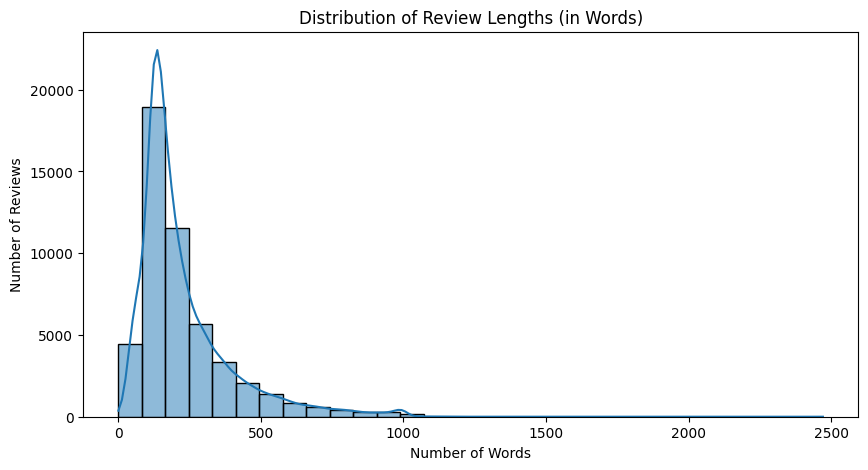

In [4]:
# Add review length column
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Summary statistics
print(df['review_length'].describe())

# Histogram of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title("Distribution of Review Lengths (in Words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

In [11]:
# Preprocessing

!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
!pip install -U spacy tqdm
import spacy
from nltk.stem import PorterStemmer
import re
from tqdm import tqdm

In [15]:
!python -m spacy download en_core_web_sm

# Load model with unnecessary parts disabled
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [16]:
tqdm.pandas()  # Enables progress bar

stemmer = PorterStemmer()

# Preprocess each Doc object (spaCy tokens)
def preprocess_doc(doc):
    tokens = [
        stemmer.stem(token.lemma_)  # lemmatize then stem
        for token in doc
        if not token.is_stop and token.is_alpha  # remove stopwords and punctuation
    ]
    return ' '.join(tokens)

# Apply processing to all texts using spaCy's pipe
def preprocess_texts_pipe(text_series):
    cleaned = [re.sub(r'<.*?>', '', text.lower()) for text in text_series]  # lowercase + remove HTML
    docs = nlp.pipe(cleaned, batch_size=32)  # efficient batch processing
    return [preprocess_doc(doc) for doc in tqdm(docs, total=len(cleaned))]

In [17]:
# Trying first on a sample of 1000
df_sample = df.sample(1000, random_state=42)
df_sample['clean_review'] = preprocess_texts_pipe(df_sample['review'])
df_sample[['review', 'clean_review']].head()

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 1000/1000 [00:19<00:00, 50.46it/s]


review  \
33553  I really liked this Summerslam due to the look...   
9427   Not many television shows appeal to quite as m...   
199    The film quickly gets to a major chase scene w...   
12447  Jane Austen would definitely approve of this o...   
39489  Expectations were somewhat high for me when I ...   

                                            clean_review  
33553  like summerslam look arena curtain look overal...  
9427   televis show appeal differ kind fan like farsc...  
199    film quickli get major chase scene increas des...  
12447  jane austen definit approv paltrow awesom job ...  
39489  expect somewhat high went movi thought steve c...

In [18]:
# On Full Dataset

df['clean_review'] = preprocess_texts_pipe(df['review'])

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 50000/50000 [14:48<00:00, 56.27it/s]


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# BoW Vectorization (Bag-of-Words)
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['clean_review'])

print("BoW shape:", X_bow.shape)

BoW shape: (50000, 5000)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_review'])

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (50000, 5000)


In [21]:
# 2.

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust the number of features

# Fit and transform the clean reviews
X_tfidf = tfidf.fit_transform(df['clean_review'])

# Check shape
print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (50000, 5000)


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize
bow = CountVectorizer(max_features=5000)

# Fit and transform
X_bow = bow.fit_transform(df['clean_review'])

# Check shape
print("BoW matrix shape:", X_bow.shape)

BoW matrix shape: (50000, 5000)


In [23]:
# Word count per review
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

# Character count (excluding spaces)
df['char_count'] = df['clean_review'].apply(lambda x: len(x.replace(" ", "")))

# Average word length
df['avg_word_length'] = df['char_count'] / df['word_count']

# Number of stopwords in original review
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['stopword_count'] = df['review'].apply(lambda x: len([w for w in x.lower().split() if w in stop_words]))

# Count of punctuation in original review
import string
df['punctuation_count'] = df['review'].apply(lambda x: len([c for c in x if c in string.punctuation]))

In [24]:
df[['clean_review', 'word_count', 'char_count', 'avg_word_length', 'stopword_count', 'punctuation_count']].sample(5)

clean_review  word_count  \
8814   andrea arriv strang citi rememb came got order...         107   
35856  best year life compar wonder life common desir...         267   
3308   saw seri london tv blown away like user commen...          96   
45066  star true qualiti half sheer enjoy incred stra...         191   
19159  grew houston movi came result rememb movi reme...          70   

       char_count  avg_word_length  stopword_count  punctuation_count  
8814          569         5.317757             126                 49  
35856        1335         5.000000             333                137  
3308          511         5.322917              97                 53  
45066         956         5.005236             160                 77  
19159         337         4.814286              76                 33

In [26]:
# 3.

# Building and Training Models

y = df['sentiment'].map({'positive': 1, 'negative': 0})  # if not already numeric

In [27]:
# Splitting the data into traning and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [29]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5000
           1       0.84      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [30]:
# Support Vector Machine (SVM)

from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("SVM Results:")
print(classification_report(y_test, y_pred_svm))

SVM Results:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5000
           1       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [31]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      5000
           1       0.85      0.83      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [32]:
# 4.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(name, y_test, y_pred):
    print(f"\n🔍 {name} Evaluation:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")


🔍 Logistic Regression Evaluation:
Accuracy:  0.8797
Precision: 0.8716
Recall:    0.8906
F1-score:  0.8810


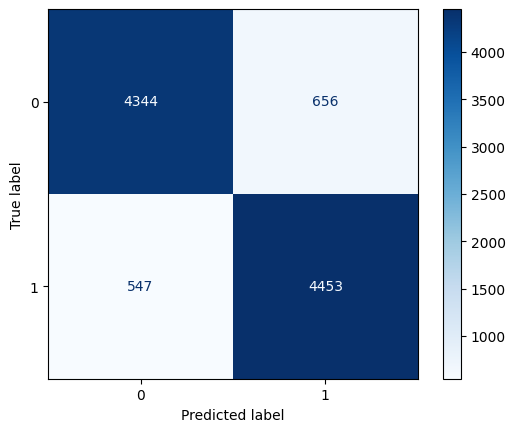

In [34]:
evaluate_model("Logistic Regression", y_test, y_pred_lr)


🔍 Naive Bayes Evaluation:
Accuracy:  0.8458
Precision: 0.8394
Recall:    0.8552
F1-score:  0.8472


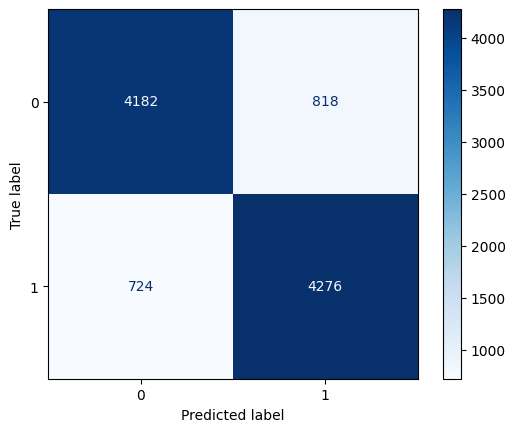

In [35]:
evaluate_model("Naive Bayes", y_test, y_pred_nb)


🔍 SVM Evaluation:
Accuracy:  0.8721
Precision: 0.8646
Recall:    0.8824
F1-score:  0.8734


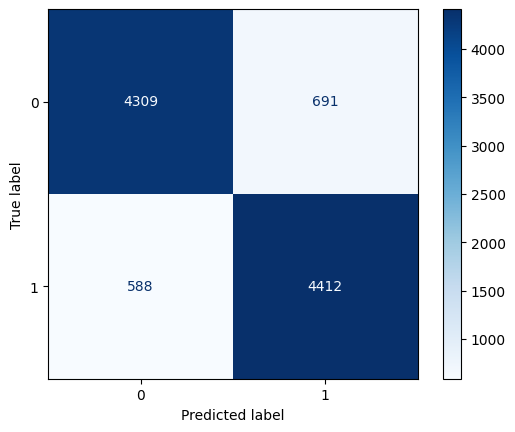

In [36]:
evaluate_model("SVM", y_test, y_pred_svm)


🔍 Random Forest Evaluation:
Accuracy:  0.8408
Precision: 0.8479
Recall:    0.8306
F1-score:  0.8392


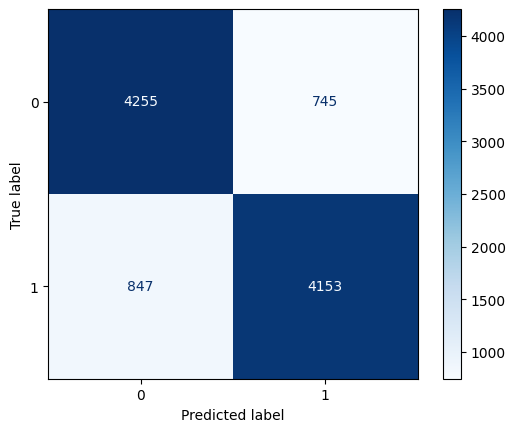

In [37]:
evaluate_model("Random Forest", y_test, y_pred_rf)

In [38]:
# Final Report

'''
Objective: To use natural language processing (NLP) and machine learning approaches
to create a machine learning classification model that reliably predicts the
sentiment (positive or negative) of IMDb movie reviews.


Checked for missing values – None found.


Verified class balance:

Positive: 50%

Negative: 50%


Preprocessing:

Converted text to lowercase

Removed HTML tags, punctuation, and special characters

Tokenized sentences into words

Removed stopwords

Applied both:

Lemmatization (to base form)

Stemming (to word root)


Feature Engineering:

Textual Features:

Word count

Character count

Average word length

Vectorization:

Bag-of-Words (BoW)

TF-IDF (used for modeling)


Model Building:
Trained and evaluated the following classification models:

Logistic Regression

Naive Bayes

Support Vector Machine (SVM)

Random Forest


Evaluated the models on accuracy, precision, recall, F1 Score.


Conclusion: The sentiment analysis model uses Logistic Regression and TF-IDF characteristics
to classify IMDb reviews with good accuracy. This process can be linked into review sites or
used for sentiment prediction in real time.

'''